In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
#!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

C:\Temp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Temp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Temp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Temp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a

2.0.0-beta1


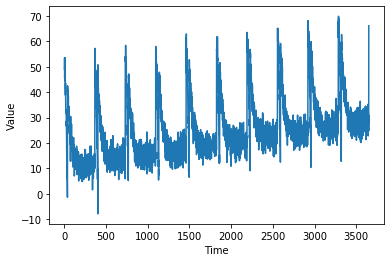

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 7.7151 - mae: 8.1173
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 7.6827 - mae: 8.0859
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 7.6473 - mae: 8.0507
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 7.6079 - mae: 8.0113
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 7.5640 - mae: 7.9675
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 7.5153 - mae: 7.9187
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 7.4614 - mae: 7.8648
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 7.4017 - mae: 7.8052
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 7.3358 - mae: 7.7391
Epoch 10/100
94/94 [==============================] - 0s 3ms

94/94 [==============================] - 0s 3ms/step - loss: 2.9664 - mae: 3.3689
Epoch 84/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9713 - mae: 3.3728
Epoch 85/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9534 - mae: 3.3602
Epoch 86/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9383 - mae: 3.3443
Epoch 87/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9427 - mae: 3.3500
Epoch 88/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9598 - mae: 3.3653
Epoch 89/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9618 - mae: 3.3652
Epoch 90/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9276 - mae: 3.3293
Epoch 91/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9200 - mae: 3.3213
Epoch 92/100
94/94 [==============================] - 0s 3ms/step - loss: 2.9564 - mae: 3.3632
Epoch 93/100
94/94 [==============================] - 0s 3ms/st

[1e-08, 0.0001, 0, 30]

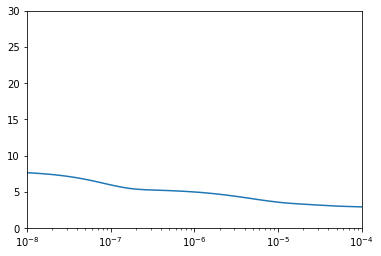

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 1s 9ms/step - loss: 53.3170 - mae: 4.3032
Epoch 2/500
94/94 [==============================] - 1s 6ms/step - loss: 34.3783 - mae: 3.6673
Epoch 3/500
94/94 [==============================] - 0s 5ms/step - loss: 31.7669 - mae: 3.5709
Epoch 4/500
94/94 [==============================] - 0s 5ms/step - loss: 30.3295 - mae: 3.5073
Epoch 5/500
94/94 [==============================] - 0s 4ms/step - loss: 29.4328 - mae: 3.4690
Epoch 6/500
94/94 [==============================] - 0s 4ms/step - loss: 28.8817 - mae: 3.4422
Epoch 7/500
94/94 [==============================] - 0s 4ms/step - loss: 28.4746 - mae: 3.4244
Epoch 8/500
94/94 [==============================] - 0s 4ms/step - loss: 28.2511 - mae: 3.4165
Epoch 9/500
94/94 [==============================] - 0s 4ms/step - loss: 27.9880 - mae: 3.4045
Epoch 10/500
94/94 [==============================] - 0s 4ms/step - loss: 27.8381 - mae: 3.3976
Epoch 11/500
94/94 [=============================

94/94 [==============================] - 0s 4ms/step - loss: 22.0480 - mae: 2.9796
Epoch 170/500
94/94 [==============================] - 0s 4ms/step - loss: 22.0063 - mae: 2.9775
Epoch 171/500
94/94 [==============================] - 0s 5ms/step - loss: 21.9906 - mae: 2.9758
Epoch 172/500
94/94 [==============================] - 0s 5ms/step - loss: 22.0058 - mae: 2.9775
Epoch 173/500
94/94 [==============================] - 0s 4ms/step - loss: 22.0559 - mae: 2.9762
Epoch 174/500
94/94 [==============================] - 0s 4ms/step - loss: 21.9393 - mae: 2.9712
Epoch 175/500
94/94 [==============================] - 0s 4ms/step - loss: 21.9212 - mae: 2.9707
Epoch 176/500
94/94 [==============================] - 0s 4ms/step - loss: 21.9976 - mae: 2.9708
Epoch 177/500
94/94 [==============================] - 0s 4ms/step - loss: 21.8978 - mae: 2.9673
Epoch 178/500
94/94 [==============================] - 0s 4ms/step - loss: 21.9310 - mae: 2.9710
Epoch 179/500
94/94 [=======================

94/94 [==============================] - 0s 4ms/step - loss: 20.2255 - mae: 2.8827
Epoch 337/500
94/94 [==============================] - 0s 4ms/step - loss: 20.2503 - mae: 2.8842
Epoch 338/500
94/94 [==============================] - 0s 4ms/step - loss: 20.3467 - mae: 2.8868
Epoch 339/500
94/94 [==============================] - 0s 4ms/step - loss: 20.2194 - mae: 2.8831
Epoch 340/500
94/94 [==============================] - 0s 4ms/step - loss: 20.2621 - mae: 2.8899
Epoch 341/500
94/94 [==============================] - 0s 4ms/step - loss: 20.3125 - mae: 2.8863
Epoch 342/500
94/94 [==============================] - 0s 4ms/step - loss: 20.2140 - mae: 2.8821
Epoch 343/500
94/94 [==============================] - 0s 4ms/step - loss: 20.1905 - mae: 2.8837
Epoch 344/500
94/94 [==============================] - 0s 4ms/step - loss: 20.1868 - mae: 2.8841
Epoch 345/500
94/94 [==============================] - 0s 4ms/step - loss: 20.1848 - mae: 2.8828
Epoch 346/500
94/94 [=======================

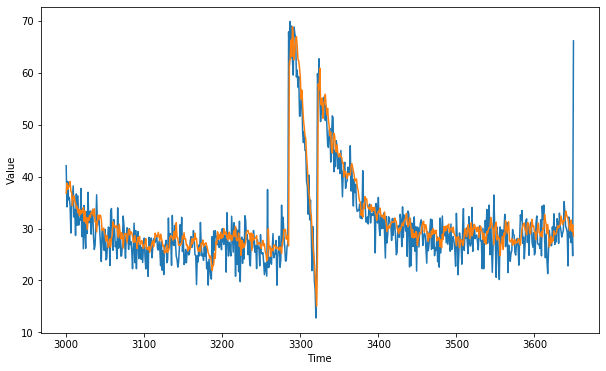

In [11]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.0843668

<Figure size 432x288 with 0 Axes>

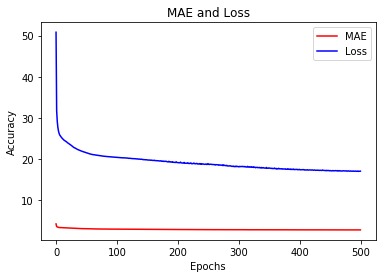

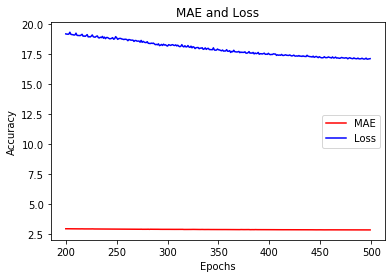

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()